/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 30/30 [01:09<00:00,  2.30s/it]


Extracting hidden states for inputs...


Processing data batches: 100%|██████████| 619/619 [12:41<00:00,  1.23s/it]


Data successfully split into training and test sets.


Training Epochs:   2%|▏         | 23/1000 [00:00<00:04, 228.26it/s]

Epoch 10/1000, Training Loss: 3.0101, Validation Loss: 2.4868
Epoch 20/1000, Training Loss: 1.3559, Validation Loss: 0.8916
Epoch 30/1000, Training Loss: 0.8434, Validation Loss: 0.6044
Epoch 40/1000, Training Loss: 0.7245, Validation Loss: 0.5442
Epoch 50/1000, Training Loss: 0.7256, Validation Loss: 0.5360


Training Epochs:   7%|▋         | 71/1000 [00:00<00:02, 374.22it/s]

Epoch 60/1000, Training Loss: 0.7176, Validation Loss: 0.5322
Epoch 70/1000, Training Loss: 0.6674, Validation Loss: 0.5071
Epoch 80/1000, Training Loss: 0.5527, Validation Loss: 0.4618
Epoch 90/1000, Training Loss: 0.4712, Validation Loss: 0.4304
Epoch 100/1000, Training Loss: 0.3981, Validation Loss: 0.4087


Training Epochs:  15%|█▍        | 148/1000 [00:00<00:02, 410.85it/s]

Epoch 110/1000, Training Loss: 0.3524, Validation Loss: 0.3920
Epoch 120/1000, Training Loss: 0.3087, Validation Loss: 0.3757
Epoch 130/1000, Training Loss: 0.3014, Validation Loss: 0.3668
Epoch 140/1000, Training Loss: 0.2706, Validation Loss: 0.3591
Early stopping at epoch 149
Test Accuracy: 0.8775


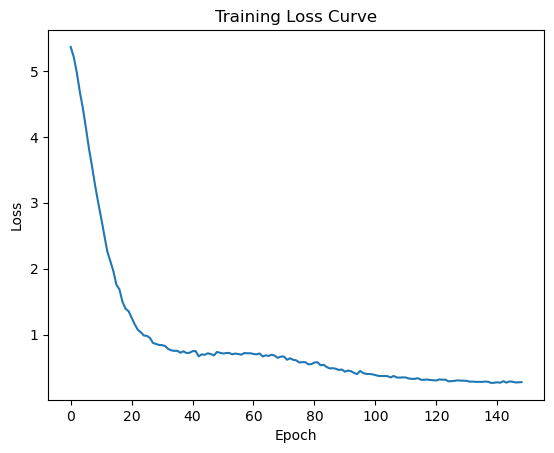

Training complete.


: 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Variables
model_name = ''
input_reference_file = ''

# Define CustomMLP for classification
class ClassificationMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationMLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, num_classes)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.dropout(x)
        x = self.activation(self.hidden2(x))
        x = self.dropout(x)
        return self.output(x)

# Load input and reference data
def load_data_for_prediction(input_file):
    """Load input and reference pairs from a JSON file."""
    with open(input_file, 'r', encoding='utf-8') as file:
        json_data = json.load(file)

    inputs = [entry['input'] for entry in json_data]
    references = [entry['reference'] for entry in json_data]

    return inputs, references

# Extract hidden states from the input text using a language model
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {key: val.to("cuda") for key, val in inputs.items()}  # Move inputs to GPU
        with torch.no_grad():
            outputs = model(**inputs)
        last_layer_hidden_states = outputs.hidden_states[-1]
        pooled_hidden_states = last_layer_hidden_states.mean(dim=1).cpu().numpy()  # Mean pooling
        hidden_states.append(pooled_hidden_states)
    return np.vstack(hidden_states)

# Train an MLP model for classification with early stopping and learning rate scheduler
def train_mlp_for_classification(X_train, y_train, X_test, y_test, input_dim, num_classes, epochs=1000, lr=0.001, patience=10):
    model = ClassificationMLP(input_dim, num_classes).to("cuda")
    criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to("cuda")
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to("cuda")  # Long tensor for classification labels
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to("cuda")
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to("cuda")

    best_loss = float('inf')
    early_stop_counter = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())

        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor).item()

        # Early stopping logic
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
            best_model = model.state_dict()  # Save best model
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

    # Load the best model weights
    model.load_state_dict(best_model)

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        test_accuracy = accuracy_score(y_test, predictions)
        print(f"Test Accuracy: {test_accuracy:.4f}")

    # Plot training loss curve
    plt.plot(losses)
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    return model

# Main workflow
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="balanced",  # Automatically balance the model across multiple GPUs
    offload_folder="offload",  # Offload weights to disk if GPU memory is insufficient
    offload_state_dict=True,
    output_hidden_states=True
)
tokenizer.pad_token = tokenizer.eos_token

# Load the input and reference data
inputs, references = load_data_for_prediction(input_reference_file)

# Encode references into labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(references)  # Encode references into integer labels
num_classes = len(label_encoder.classes_)  # Number of unique references

# Extract hidden states for the inputs
print("Extracting hidden states for inputs...")
X_hidden_states = extract_hidden_states(inputs, model, tokenizer)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_hidden_states, y_labels, test_size=0.3, random_state=42)

print("Data successfully split into training and test sets.")

# Define MLP parameters and train the model
input_dim = X_train.shape[1]
trained_model = train_mlp_for_classification(X_train, y_train, X_test, y_test, input_dim, num_classes)
print("Training complete.")
